# Introduction 
Following through [this excellent tutorial](https://rpubs.com/adam_dennett/257231) by Adam Dennett on geospatial flow modelling. The focus of this notebook is:
- Getting and cleaning data on commuter flows from StatsNZ
- Plotting the flow data onto the territorial authorities map for Wellington
- Findng the data equivalents used in the RPubs analysis for Wellington 
- Presenting and understanding the basic unconstrained model of spatial flows

# Package installation
I'm working from a Ubuntu 18.04 VM on Windows. I needed to install a bunch of additional linux packages for the necessary R libraries and their dependencies:
- sudo apt  install protobuf-compiler
- sudo apt install libprotobuf-dev
- sudo apt install libv8-3.14-dev
- sudo apt-get install libjq-dev
- sudo apt install libudunits2-dev
- sudo apt install libgdal-dev
- sudo apt install libgdal1-dev (though I'm not 100% sure of this one)


In [22]:
library(sp)
library(MASS)
library(reshape2)
library(geojsonio)
library(rgdal)
library(downloader)
library(maptools)
library(tmap)
library(dplyr)
library(broom) 
library(stplanr)
library(ggplot2)
library(leaflet)
library(sf)

# Load user modules
source("utils/data_processing.R")
source("utils/model_processing.R")

# Notebook configurations
options(warn=-1) # Turn on Warnings with warn=0
options(repr.plot.width=4, repr.plot.height=3)

# Data
There 4 key data sources for spatial flow modelling: 
- Geography shape file of the region
- Flow data
- Destination "attractiveness" features
- Origin "migration propensity" features

All 4 data sources have to be aggregated at the same spatial unit level. For this example, I've chosen to go with "statistical area 2" spatial unit. This is a mid-level coarse graining of the Wellington TA that loosely corresponds to suburbs. 

Data | Source 
--- | --- 
Geography shape file of the region | Stats NZ
Flow data | Stats NZ Commuter Flows visualisation
Destination "attractiveness" features | Mean personal income calculated from # people in income brackets
Origin "migration propensity" features | Population

Some notes: 
- Mean income is calculated from the coarse income brackets using the mid-bracket value. Because of the bracketing, it's only possible to calculate the mean, not the preferred median. I don't feel that this is a robust calculation since (1) the larger income brackets are much wider, and (2) the very high income bracket is not bounded - it's $150,000 and above.  
- Population value to use? As a simple approximating, we can use the number of commuting adults as the "population" - though it's the working, commuting, adult population of the area. 

## Getting flow data
Commuter flows from the NZ census are not available in a handy tabular format. But StatsNZ have provided a [Beta version of a commuter flow interactive map](https://www.stats.govt.nz/tools/commuter-view). I manually downloaded the flow data for each of the wards within the Wellington City territorial authority. The data is limited because the Wellington City TA doesn't capture the Hutt Valley or Porirua - two key suburban areas of the Greater Wellington region. Once I have a basic version of the model running, I'll extract the complete dataset. 

In [2]:
df_flow <- readCommuterFlows("data/commuter_flow_wellington_city.csv")

In [3]:
df_flow_clean <- df_flow %>% filter(to_name %in% from_name) %>% filter(flow_type == 'out')
df_flow_clean %>% head()

to_code,to_name,flow_type,year_2006,year_2013,from_code,from_name
575300,Kelburn,out,9,9,576500,Adelaide
576901,Kilbirnie East,out,9,6,576500,Adelaide
573000,Lambton,out,114,138,576500,Adelaide
573400,Mt Victoria West,out,9,6,576500,Adelaide
576400,Newtown East,out,9,12,576500,Adelaide
576301,Newtown West,out,6,9,576500,Adelaide


## Get origin and destination features

In [10]:
income_df <- read.csv("data//wellington-city-ta-personal-income-bracket.csv", sep=';', strip.white=T)
income_df <- tibble::rownames_to_column(income_df)
income_df %>% head()

rowname,ward,Total.people..total.personal.income,Loss,Zero.income,X.1..5.000,X.5.001..10.000,X.10.001..15.000,X.15.001..20.000,X.20.001..25.000,⋯,X.30.001..35.000,X.35.001..40.000,X.40.001..50.000,X.50.001..60.000,X.60.001..70.000,X.70.001..100.000,X.100.001..150.000,X.150.001.or.more,Total.people.stated,Not.stated
Tawa South,NA,2838,6,192,192,132,183,195,180,⋯,120,111,237,216,153,333,216,90,2676,159
Tawa Central,NA,3444,9,282,207,150,213,261,222,⋯,165,174,321,267,219,372,156,42,3231,213
Linden,NA,3123,18,285,204,174,201,231,186,⋯,144,180,294,222,183,246,117,42,2883,240
Greenacres,NA,1239,0,102,75,60,63,66,63,⋯,45,48,111,105,75,177,84,39,1182,54
Thorndon-Tinakori Road,NA,3804,12,141,162,156,195,195,153,⋯,135,165,369,348,267,522,312,255,3543,261
Lambton,NA,5451,24,405,762,573,420,258,216,⋯,171,195,387,339,222,420,282,159,4989,462


In [24]:
income_vals <- cleanIncomeData(income_df)
df_mean_income <- calculateMeanIncome(income_vals, df_flow_clean)

Using statistical_area as id variables
Joining, by = "statistical_area"


In [25]:
colnames(income_vals)[1:length(colnames(income_vals)) - 1]

[1] "Zero.income"        "X.1..5.000"         "X.5.001..10.000"   
 [4] "X.10.001..15.000"   "X.15.001..20.000"   "X.20.001..25.000"  
 [7] "X.25.001..30.000"   "X.30.001..35.000"   "X.35.001..40.000"  
[10] "X.40.001..50.000"   "X.50.001..60.000"   "X.60.001..70.000"  
[13] "X.70.001..100.000"  "X.100.001..150.000" "X.150.001.or.more"

In [26]:
df_commuter_popn <- df_flow %>% 
                    filter(to_name %in% from_name) %>%
                    filter(flow_type == "out") %>%
                    group_by(from_name) %>%
                    summarise(commuting_popn = sum(year_2013))

## Get Statistical Area Unit boundaries

In [27]:
wgtn <- readOGR("./data/wgtn-stat-area-2", layer="AU_TA_Wellington_CC")
wgtn

OGR data source with driver: ESRI Shapefile 
Source: "/home/shrividya/Documents/wellington-commutes/data/wgtn-stat-area-2", layer: "AU_TA_Wellington_CC"
with 68 features
It has 5 fields


class       : SpatialPolygonsDataFrame 
features    : 68 
extent      : 2645098, 2669062, 5981296, 6005477  (xmin, xmax, ymin, ymax)
coord. ref. : +proj=nzmg +lat_0=-41 +lon_0=173 +x_0=2510000 +y_0=6023150 +datum=nzgd49 +units=m +no_defs +ellps=intl +towgs84=59.47,-5.04,187.44,0.47,-0.1,1.024,-4.5993 
variables   : 5
names       :  UID_AU_TA,  AU_NO, TA_NO,      AU_NAME,         TA_NAME 
min values  : 572500|047, 572500,   047,     Adelaide, Wellington City 
max values  : 577700|047, 577700,   047, Wilton-Otari, Wellington City 

# Data Munging

## Calculate pairwise distances

In [28]:
# Calculate and tabulate pairwise distances
nz_grid = "+init=epsg:2193"
wgtn_grid <- spTransform(wgtn, nz_grid)
df_distance <- melt(spDists(wgtn_grid))

## Geo-munging

In [29]:
# Create the lookup dataframes to match with the pairwise distance dataframe
# Names dataframe: numeric sequence --> Name
names <- as.data.frame(as.character(wgtn$AU_NAME))
names$num <- seq(1, nrow(names))
colnames(names) <- c('name', 'num')

# Code dataframe: Name --> GeoCode
code_df <- data.frame(wgtn$UID_AU_TA, wgtn$AU_NAME)
colnames(code_df) <- c('UID_AU_TA', 'geo_code')

In [30]:
df_distance_clean <- labelledPairwiseDistance(df_distance, code_df, names)
df_model <- dataForFlowModel(df_distance_clean, df_flow_clean, df_commuter_popn, df_mean_income)

## Plotting some flows

In [31]:
#use the od2line function from stplanr
df_model_sub <- df_model %>% select(Orig_Code, Dest_Code, year_2013) %>% sample_n(20)
travel_network <- od2line(flow = df_model_sub,  zones = wgtn)
travel_networkwgs <- spTransform(travel_network, nz_grid)

#and set the line widths to some sensible value according to the flow
w <- df_model_sub$year_2013 / max(df_model_sub$year_2013) * 10

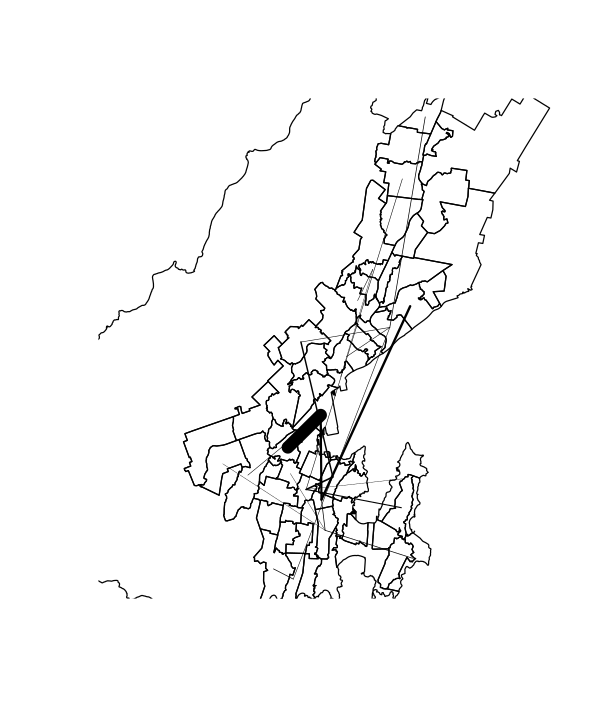

In [32]:
options(repr.plot.width=5, repr.plot.height=6)
plot(travel_networkwgs, lwd = w)
plot(wgtn_grid, add=T)

# Spatial flow modelling


$$
T_{ij} = k\frac{P_i P_j}{D_{ij}}
$$

Additional parameters for the model that take some system variability into account. 

$$
T_{ij} = k\frac{P^{\alpha}_i P^{\lambda}_j}{D^{\beta}_{ij}}
$$

Variability is expressed as:

Parameter | meaning | explanation 
--- | --- | ---
$\alpha$ | emissivity | Potential of origin to generate movement
$\lambda$ | attractiveness | Potential of destination to attract movement
$\beta$ | transport frictions | Issues in commuting transport systems

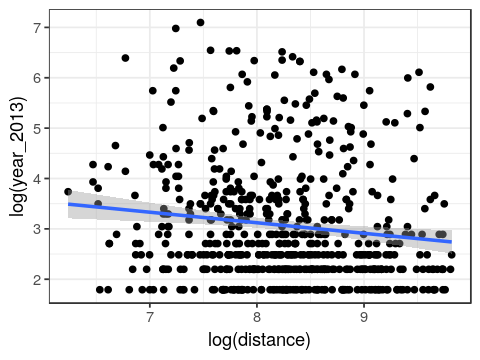

In [33]:
options(repr.plot.width=4, repr.plot.height=3)
qplot(log(distance), log(year_2013), data=df_model) + geom_smooth(method = lm) + theme_bw()

## Poisson GLM

In [34]:
#run the unconstrained model
uncosim <- glm(year_2013 ~ log(commuting_popn) + log(mean_calc_income) + log(distance), 
               na.action = na.exclude, family = poisson(link = "log"), data = df_model)

# Add fit to df 
df_model$fitted <- fitted(uncosim)
summary(uncosim)


Call:
glm(formula = year_2013 ~ log(commuting_popn) + log(mean_calc_income) + 
    log(distance), family = poisson(link = "log"), data = df_model, 
    na.action = na.exclude)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-13.520   -7.889   -5.739   -2.705   57.993  

Coefficients:
                       Estimate Std. Error z value Pr(>|z|)    
(Intercept)           13.267027   0.240052   55.27   <2e-16 ***
log(commuting_popn)    0.476339   0.009074   52.50   <2e-16 ***
log(mean_calc_income) -1.008664   0.020937  -48.18   <2e-16 ***
log(distance)         -0.210736   0.007455  -28.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 75317  on 597  degrees of freedom
Residual deviance: 69426  on 594  degrees of freedom
AIC: 72377

Number of Fisher Scoring iterations: 6


In [35]:
df_model %>% filter(to == 'Lambton') %>% select(from, to, mean_calc_income, year_2013, fitted) %>% head()

from,to,mean_calc_income,year_2013,fitted
Johnsonville East,Lambton,38917.37,132,31.96957
Newlands North,Lambton,38917.37,312,51.27917
Grenada Village,Lambton,38917.37,168,34.81375
Mt Victoria West,Lambton,38917.37,1209,122.48224
Johnsonville North,Lambton,38917.37,234,42.82457
Aro Street-Nairn Street,Lambton,38917.37,564,94.10448


In [36]:
CalcRSquared(df_model$year_2013, df_model$fitted)

[1] 0.03963358

# A better model

- The model we've implemented is terrible - it captures none of the variance. That's because:
    - The destination importance feature is hopeless.
    - There is a large asymmetry in destination importance that the features need to capture. 

The asymmetry in attractiveness exists most of the offices exist in the downtown part of Wellington. Weekly commutes are thus mostly captured by inflows from all over the Wellington region to a relatively small part of the inner city. One way to possibly capture this as a feature is by aggregating the number of commercial type buildings within a given statistical area. We can get the commercial building data with [this Overpass query](http://overpass-turbo.eu/s/BHN). 

# Data Issues

In [37]:
names_income_df <- as.character(df_mean_income$statistical_area)
names_map <- as.character(wgtn$AU_NAME)

setdiff(names_income_df, names_map)
setdiff(names_map, names_income_df)

[1] "Ngaio South"                     "Khandallah Park-Broadmeadows"   
 [3] "Churton Park North"              "Crofton Downs"                  
 [5] "Hataitai North"                  "Wilton"                         
 [7] "Melrose-Houghton Bay-Southgate"  "Churton Park South"             
 [9] "Kilbirnie West-Hataitai South"   "Willis Street-Cambridge Terrace"
[11] "Lyall Bay-Airport-Moa Point"     "Paparangi"                      
[13] "Johnsonville Central"            "Paparangi West"                 
[15] "Miramar"                         "Berhampore West"                
[17] "Miramar West"

[1] "Johnsonville East"              "Grenada Village"               
 [3] "Johnsonville South"             "Kingston"                      
 [5] "Taitville"                      "Mitchelltown"                  
 [7] "Vogeltown"                      "Horokiwi"                      
 [9] "Awarua"                         "Rangoon Heights"               
[11] "Glenside North"                 "Newlands East"                 
[13] "Hataitai"                       "Willis Street-Cambridge Terrac"
[15] "Roseneath"                      "Brooklyn South"                
[17] "Melrose"                        "Berhampore"                    
[19] "Kilbirnie West"                 "Ngaio"                         
[21] "Churton"                        "Karaka Bay-Worser Bay"         
[23] "Karori Park"                    "Takapu"                        
[25] "Lyall Bay"                      "Wilton-Otari"                  
[27] "Wellington City-Marinas"        "Khandallah Park"               
[29] "Evans Bay Marina"